In [2]:
#Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

In [4]:
#Load dataset
data=pd.read_csv("annual_aqi_by_county_2025.csv")

In [5]:
print(data.head)

<bound method NDFrame.head of        State      County  Year  Days with AQI  Good Days  Moderate Days  \
0    Alabama     Baldwin  2025             88         63             25   
1    Alabama        Clay  2025             90         74             15   
2    Alabama      DeKalb  2025            120         94             26   
3    Alabama      Elmore  2025             31         29              2   
4    Alabama      Etowah  2025             88         61             27   
..       ...         ...   ...            ...        ...            ...   
928  Wyoming    Sheridan  2025            120         96             24   
929  Wyoming    Sublette  2025            120         88             32   
930  Wyoming  Sweetwater  2025            118        110              8   
931  Wyoming       Teton  2025            177        156             21   
932  Wyoming    Washakie  2025            171        167              4   

     Unhealthy for Sensitive Groups Days  Unhealthy Days  Very Unheal

In [6]:
df=data.copy()
# Data cleaning and preprocessing
col_map_candidates = {
    'Days Good': ['Days Good', 'Days_Good', 'Days Good (AQI)'],
    'Days Moderate': ['Days Moderate', 'Days_Moderate'],
    'Days Unhealthy for Sensitive Groups': ['Days Unhealthy for Sensitive Groups', 'Days Unhealthy for Sensitive Groups'],
    'Days Unhealthy': ['Days Unhealthy', 'Days_Unhealthy'],
    'Days Very Unhealthy': ['Days Very Unhealthy', 'Days_Very_Unhealthy'],
    'Days Hazardous': ['Days Hazardous', 'Days_Hazardous'],
    'Max AQI': ['Max AQI', 'Max_AQI'],
    'Median AQI': ['Median AQI', 'Median_AQI']
}
for canonical, alts in col_map_candidates.items():
    for alt in alts:
        if alt in df.columns:
            df = df.rename(columns={alt: canonical})
            break

In [7]:
# Trim whitespace
for c in df.select_dtypes(include='object').columns:
    df[c] = df[c].str.strip()

# Ensure State & County columns exist (attempt)
if 'State' not in df.columns:
    possible = [c for c in df.columns if 'state' in c.lower()]
    if possible:
        df = df.rename(columns={possible[0]: 'State'})

if 'County' not in df.columns:
    possible = [c for c in df.columns if 'county' in c.lower()]
    if possible:
        df = df.rename(columns={possible[0]: 'County'})

In [8]:
# Coerce numeric columns where present
numeric_cols = ['Year','Max AQI','Median AQI','Days Good','Days Moderate',
                'Days Unhealthy for Sensitive Groups','Days Unhealthy','Days Very Unhealthy','Days Hazardous']
for c in numeric_cols:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors='coerce')

# Drop rows missing core info
df = df.dropna(subset=['State','County','Year'], how='any')
print("After canonicalization shape:", df.shape)
print(df.sample(5))

After canonicalization shape: (933, 18)
            State    County  Year  Days with AQI  Good Days  Moderate Days  \
700   Puerto Rico    Catano  2025             87         69             18   
577  North Dakota  Burleigh  2025            121        116              5   
796         Texas      Webb  2025             91         63             28   
853    Washington   Cowlitz  2025             90         74             16   
865    Washington   Pacific  2025             90         90              0   

     Unhealthy for Sensitive Groups Days  Unhealthy Days  Very Unhealthy Days  \
700                                    0               0                    0   
577                                    0               0                    0   
796                                    0               0                    0   
853                                    0               0                    0   
865                                    0               0                    0   

    

In [9]:
# Determine day columns present
day_cols = [c for c in ['Days Good','Days Moderate','Days Unhealthy for Sensitive Groups',
                        'Days Unhealthy','Days Very Unhealthy','Days Hazardous'] if c in df.columns]

# Total monitored days (sum of day categories)
df['Total_AQI_Days'] = df[day_cols].sum(axis=1, skipna=True)

In [10]:
# Sum of unhealthy categories and percent unhealthy
unhealthy_cols = [c for c in ['Days Unhealthy','Days Very Unhealthy','Days Hazardous'] if c in df.columns]
df['Days_Unhealthy_sum'] = df[unhealthy_cols].sum(axis=1, skipna=True)
df['Pct_Unhealthy'] = (df['Days_Unhealthy_sum'] / df['Total_AQI_Days']).replace([np.inf, -np.inf], np.nan).fillna(0)

# If Median AQI missing but Max AQI present, impute simple median
if 'Median AQI' not in df.columns and 'Max AQI' in df.columns:
    df['Median AQI'] = df['Max AQI'] * 0.6

# Drop rows missing Max AQI (target for regression)
df = df.dropna(subset=['Max AQI']).reset_index(drop=True)
print("After feature engineering shape:", df.shape)
display(df.head())

After feature engineering shape: (933, 21)


,State,County,Year,Days with AQI,Good Days,Moderate Days,Unhealthy for Sensitive Groups Days,Unhealthy Days,Very Unhealthy Days,Hazardous Days,...,90th Percentile AQI,Median AQI,Days CO,Days NO2,Days Ozone,Days PM2.5,Days PM10,Total_AQI_Days,Days_Unhealthy_sum,Pct_Unhealthy
0,Alabama,Baldwin,2025,88,63,25,0,0,0,0,...,55,42,0,0,21,67,0,0.0,0.0,0.0
1,Alabama,Clay,2025,90,74,15,1,0,0,0,...,59,30,0,0,0,90,0,0.0,0.0,0.0
2,Alabama,DeKalb,2025,120,94,26,0,0,0,0,...,57,41,0,0,96,24,0,0.0,0.0,0.0
3,Alabama,Elmore,2025,31,29,2,0,0,0,0,...,48,41,0,0,31,0,0,0.0,0.0,0.0
4,Alabama,Etowah,2025,88,61,27,0,0,0,0,...,58,43,0,0,18,70,0,0.0,0.0,0.0


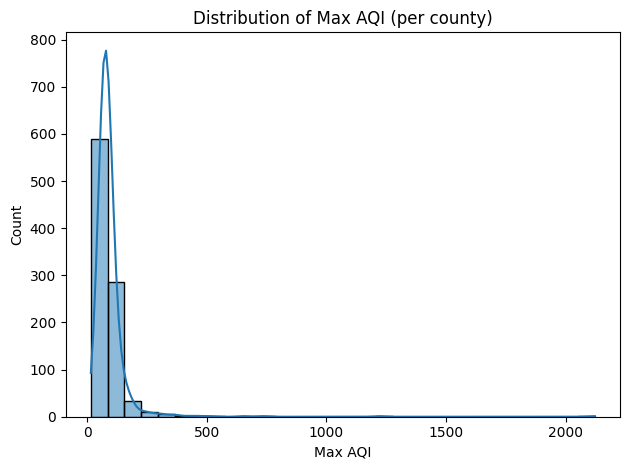

In [11]:
# EDA :Distributions and boxplots
# Histogram of Max AQI
plt.figure()
sns.histplot(df['Max AQI'], bins=30, kde=True)
plt.title('Distribution of Max AQI (per county)')
plt.xlabel('Max AQI'); plt.ylabel('Count')
plt.tight_layout()
plt.show()

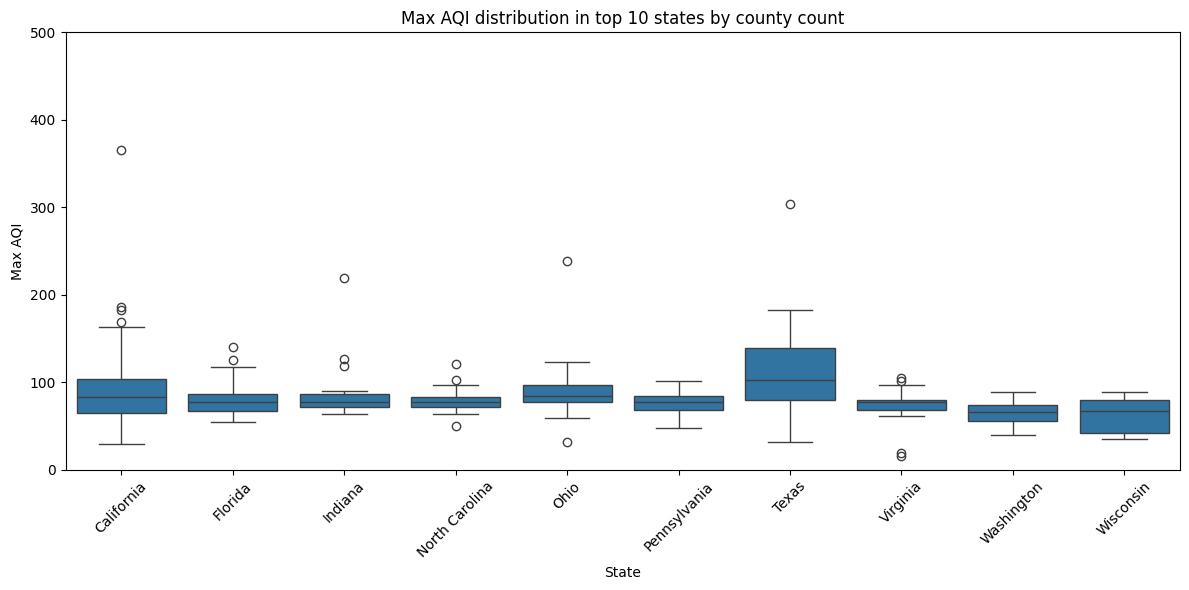

In [13]:
# Boxplot of Max AQI for top 10 states by county count
top_states = df['State'].value_counts().nlargest(10).index.tolist()
plt.figure(figsize=(12,6))
sns.boxplot(data=df[df['State'].isin(top_states)], x='State', y='Max AQI')
plt.ylim(0, 500) 
plt.title('Max AQI distribution in top 10 states by county count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

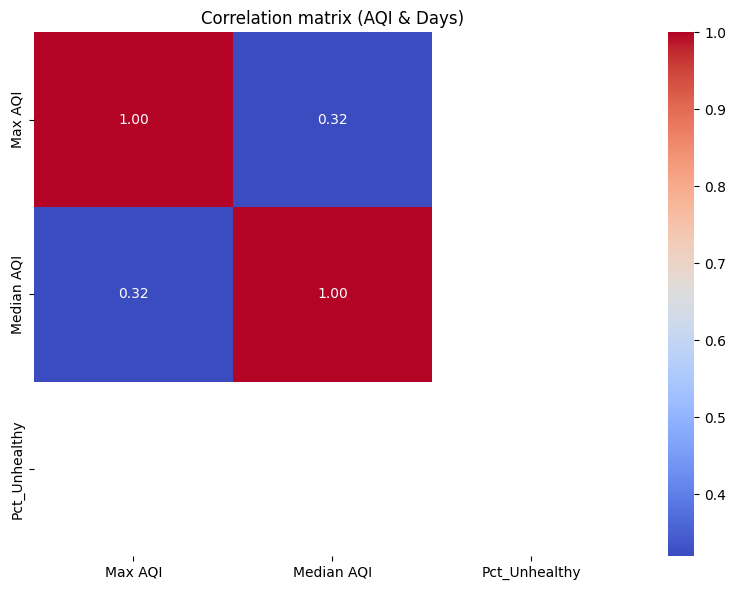

In [14]:
# EDA: Correlation and top countries
num_for_corr = [c for c in ['Max AQI','Median AQI'] + day_cols + ['Pct_Unhealthy'] if c in df.columns]
plt.figure(figsize=(8,6))
sns.heatmap(df[num_for_corr].corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation matrix (AQI & Days)')
plt.tight_layout()
plt.show()

In [15]:
# Top 10 worst counties by Max AQI
top10 = df.sort_values('Max AQI', ascending=False).head(10)
print("Top 10 counties by Max AQI:")
display(top10[['State','County','Year','Max AQI']])

Top 10 counties by Max AQI:


,State,County,Year,Max AQI
766,Texas,El Paso,2025,2122
28,Arizona,Pinal,2025,1215
446,Missouri,St. Louis City,2025,738
106,Colorado,Prowers,2025,652
638,Oklahoma,Tulsa,2025,508
633,Oklahoma,Oklahoma,2025,459
506,New Mexico,Dona Ana,2025,424
285,Kansas,Sumner,2025,370
24,Arizona,Maricopa,2025,366
67,California,Riverside,2025,365


In [16]:
# Compute key statistical measures
stats = {}
stats['mean_max_aqi'] = df['Max AQI'].mean()
stats['std_max_aqi'] = df['Max AQI'].std()
stats['median_max_aqi'] = df['Max AQI'].median()
if 'Pct_Unhealthy' in df.columns:
    stats['corr_pct_unhealthy_maxaqi'] = df[['Pct_Unhealthy','Max AQI']].corr().iloc[0,1]
print("Key statistics:")
for k,v in stats.items():
    print(f"{k}: {v}")

Key statistics:
mean_max_aqi: 92.82851018220794
std_max_aqi: 92.84260621958549
median_max_aqi: 78.0
corr_pct_unhealthy_maxaqi: nan


In [18]:
# Create Risk categories (for classification)
def assign_risk(aqi):
    if pd.isna(aqi):
        return np.nan
    if aqi < 50:
        return 'Low'
    elif aqi <= 100:
        return 'Moderate'
    else:
        return 'High'

df['Risk'] = df['Max AQI'].apply(assign_risk)
print("Risk value counts:")
display(df['Risk'].value_counts(dropna=False))

Risk value counts:


Risk
Moderate    678
High        198
Low          57
Name: count, dtype: int64